# Подготовка данных и обучение нейронных сетей:

In [1]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import random
import torch, torchvision
from  matplotlib import pyplot as plt
from PIL import Image 
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time 
import torchvision.utils as vutils
from torchvision import transforms, models
import cv2
from bs4 import BeautifulSoup
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
%matplotlib inline

In [2]:
# Для воспроизводимости результатов зафиксируем сиды:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

## Реализуем обучение нейронной сети, выполняющей детектирование объектов класса "person"

Имеется заранее размеченный датасет. Закачать можно по этой [ссылке](https://disk.yandex.ru/d/7HNoc81at3r6VQ)

Реализуем аугментацию данных, увеличив датасет вдвое. Для этого написал кастомную функцию aug:

In [2]:
from augmentation import *
aug(out_folder='augmented_dataset')

Исходное число фотографий и аннотаций = 500
Итоговое число фотографий и аннотаций = 1000


___

### Преподготовка данных для обучения сети Faster RCNN:

Разделим данные на тренировочные и тестовые:

In [3]:
# Получим имена файлов без значения кодировки
names = []
for file in os.listdir('augmented_dataset/images'):
    names.append(file.split('.')[0])

Рандомно поделим фотографии на train (80%) и test (20%)

In [9]:
train_data = random.sample(names, int(len(names) * 0.8))
print(f'Число изображений на train = {len(train_data)}')
test_data = list(set(names) - set(train_data))
print(f'Число изображений на test = {len(test_data)}')

Число изображений на train = 800
Число изображений на test = 200


В файле data_analysis.ipynb мы поработали с данными в формате json. Теперь рассмотрим как работать работать с аналогичными данными, но представленными в формате xml

In [10]:
with open('detect_dataset/annotations/PASCAL_VOC_xml/oz7_violation_frame519.xml') as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')
        num_objs = len(objects)
print(objects)

[<object>
<name>person</name>
<truncated>0</truncated>
<occluded>0</occluded>
<difficult>0</difficult>
<bndbox>
<xmin>1000.3</xmin>
<ymin>301.6</ymin>
<xmax>1082.3</xmax>
<ymax>514.5</ymax>
</bndbox>
</object>, <object>
<name>person</name>
<truncated>0</truncated>
<occluded>0</occluded>
<difficult>0</difficult>
<bndbox>
<xmin>1140.9</xmin>
<ymin>260.36</ymin>
<xmax>1215.6</xmax>
<ymax>493.2</ymax>
</bndbox>
</object>]


В данном случае информативная информация представлена в разделе _xmin_, _ymin_, _xmax_, _ymax_ и сам класс представлен в разделе _name_

In [18]:
# Создадим функции, которые как раз распарсят эти данные:
def generate_box(obj):
    xmin = int(float(obj.find('xmin').text))
    ymin = int(float(obj.find('ymin').text))
    xmax = int(float(obj.find('xmax').text))
    ymax = int(float(obj.find('ymax').text))
    return [xmin, ymin, xmax, ymax]

'''
класс человек - 1
p.s:
    Я заранее прописал условия номеров классов
    для обучении следующей сети с двумя классами:
      1 -  человек с каской
      2 -  человек без каски
'''
def generate_label(obj):
    if (obj.find('name').text == "person") or (obj.find('name').text == "hat"):
        return 1
    elif obj.find('name').text == "no_hat":
        return 2   
    return 0

Pytorch как раз при обучении для моделей детекции тредует данные в формате [xmin, ymin, xmax, ymax] для каждого бокса

In [13]:
'''
Эта функция будет выдавать на выходе словарь с 3 ключами: boxes, labels и image_id.
На вход функция принимает:
image_id - индекс фотки из Dataset класса Pytorch 
file - путь к xml файлу
'''
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')
        num_objs = len(objects)

        # Будем итерироваться по листу, полученному после раскрытия xml файла:
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # В данном случае всего 1 класс 
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # переведем индекс торч тензор
        img_id = torch.tensor([image_id])

        # получим итоговый словарь для исследуемой фотографии
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target

In [14]:
class MakeDataset(Dataset):
    def __init__(self, data, transforms=None):
        self.transforms = transforms
        self.names_list = data

    def __getitem__(self, idx):
        name = self.names_list[idx]
        file_image = 'detect_dataset/images/' + str(name) + '.jpg'
        file_label = 'detect_dataset/annotations/PASCAL_VOC_xml/' + str(name) + '.xml'
        img = Image.open(file_image).convert("RGB")

        #Сделаем словарь с аннотацией с помощью ранее написанной функции:
        target = generate_target(idx, file_label)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.names_list)

In [15]:
data_transform = transforms.Compose([
        transforms.ToTensor()
    ])

train_dataset = MakeDataset(train_data, transforms=data_transform)

Посмотрим в каком формате данные харнятся в классе Датасет:

In [17]:
first = train_dataset[6]
features, labels = first
print(labels)

{'boxes': tensor([[ 998.,  266., 1105.,  491.],
        [1143.,  291., 1216.,  479.]]), 'labels': tensor([1, 1]), 'image_id': tensor([6])}


В данном случае на фотке есть 2 объекта класса человек, поэтому 2 bounding бокса

In [24]:
def collate_fn(batch):
    return tuple(zip(*batch))

batch_size = 5  # Зададим чило фотографий на 1 батч

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=5, collate_fn=collate_fn)

---

Будем использовать Transfer learning подход, обучая сеть Faster RCNN, которая была уже предобучена на COCO

In [25]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Заменим число выходных класссов на то, что нам нужно
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [26]:
# Будем обучать на видеокарте:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [27]:
# Зададим модель (число классов задал как n+1, так как пустой 0 класс)
model = get_model_instance_segmentation(2)

d:\Program files 2.0\Anaconda\envs\GPU\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Program files 2.0\Anaconda\envs\GPU\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Демонстрация выходных данных в класса DataLoader

In [34]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in train_data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 392.,  575.,  680., 1080.],
        [1009.,  830., 1305., 1080.],
        [ 946.,  423., 1080.,  790.]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}, {'boxes': tensor([[1209.,  127., 1269.,  238.],
        [1175.,  155., 1249.,  329.]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'image_id': tensor([1], device='cuda:0')}, {'boxes': tensor([[1245.,   77., 1298.,  225.],
        [1291.,   78., 1341.,  225.]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'image_id': tensor([2], device='cuda:0')}, {'boxes': tensor([[ 776.,  494.,  917.,  847.],
        [1126.,  189., 1195.,  348.]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'image_id': tensor([3], device='cuda:0')}]


Визуализируем исходные изображения:

In [35]:
num_epochs = 3
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(train_data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in train_data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(epoch_loss)

Iteration: 1/100, Loss: 1.0322420597076416
Iteration: 2/100, Loss: 0.5314993858337402
Iteration: 3/100, Loss: 0.4557686150074005
Iteration: 4/100, Loss: 0.3608205318450928
Iteration: 5/100, Loss: 0.39796191453933716
Iteration: 6/100, Loss: 0.35083070397377014
Iteration: 7/100, Loss: 0.5852155089378357
Iteration: 8/100, Loss: 0.44727054238319397
Iteration: 9/100, Loss: 0.17009013891220093
Iteration: 10/100, Loss: 0.3326820433139801
Iteration: 11/100, Loss: 0.28661003708839417
Iteration: 12/100, Loss: 0.14862960577011108
Iteration: 13/100, Loss: 0.14380903542041779
Iteration: 14/100, Loss: 0.13507400453090668
Iteration: 15/100, Loss: 0.17103353142738342
Iteration: 16/100, Loss: 0.20875601470470428
Iteration: 17/100, Loss: 0.2072973996400833
Iteration: 18/100, Loss: 0.41072288155555725
Iteration: 19/100, Loss: 0.12084625661373138
Iteration: 20/100, Loss: 0.23879465460777283
Iteration: 21/100, Loss: 0.2245197743177414
Iteration: 22/100, Loss: 0.26697680354118347
Iteration: 23/100, Loss: 0.

тестирование:

In [265]:
name = test_data[17]
file_image = 'detect_dataset/images/' + str(name) + '.jpg'
image = Image.open(file_image).convert("RGB")
test_im = data_transform(image)

In [266]:
test_im.size()

torch.Size([3, 1080, 1920])

In [267]:
device = 'cpu'
model = model.to(device)

In [268]:
test_im = test_im[ None, :, :, :]
test_im = test_im.to(device)

In [269]:
model.eval()
preds = model(test_im)
preds

[{'boxes': tensor([[ 754.4659,  522.5803,  874.5791,  930.7663],
          [ 836.5839,  479.2756, 1013.7266,  954.8871],
          [   5.2610,  950.5646,  123.4371, 1078.1361]],
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1]),
  'scores': tensor([0.9809, 0.9800, 0.6908], grad_fn=<IndexBackward0>)}]

In [270]:
test_im = test_im[0].to("cpu")
test_im = np.transpose(test_im,(1,2,0))
test_im.size()

torch.Size([1080, 1920, 3])

In [271]:
test_im = test_im.numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


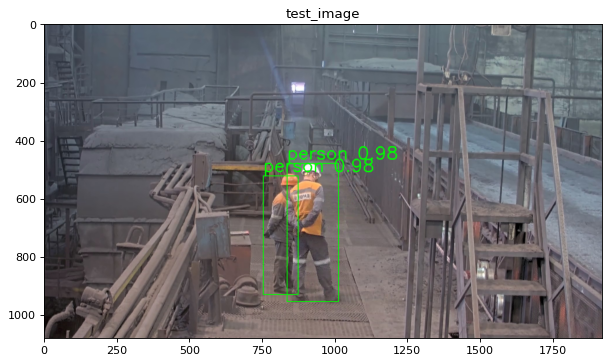

In [272]:
# Реализация построения результата детекции тестовой картинки
treshhold = 0.8  # Задалим порог. Если score больше порога, то выделяем бокс
plt.figure(figsize=(9, 7), dpi=80)
plt.title(f'test_image')
image = test_im.copy() 
class_detect = ['none','person']
for i in range(preds[0]['boxes'].size()[0]):
        if float(preds[0]['scores'][i]) > treshhold:
                [xmin, ymin, xmax, ymax] = preds[0]['boxes'][i]
                xmin = int(xmin)
                ymin = int(ymin)
                xmax = int(xmax)
                ymax = int(ymax)
                text = class_detect[int(preds[0]['labels'][i])] + ' ' + \
                  str(round(float(preds[0]['scores'][i]),2))
                image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
                image = cv2.putText(image, text, (xmin, ymin - 15),
                                    cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)
plt.imshow(image)
plt.show()